In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [24]:
# 한글 폰트 설정 (Windows 환경)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("🚀 학생 중도이탈율 예측 모델 구축을 시작합니다!")
print("=" * 60)

🚀 학생 중도이탈율 예측 모델 구축을 시작합니다!


In [25]:
# 1. 데이터 로드 (Google Colab 코드 제거)
try:
    data = pd.read_csv('data/processed_student_data.csv')  # 실제 파일명으로 변경
    print(f"✅ 데이터 로드 완료: {data.shape}")
except FileNotFoundError:
    print("❌ CSV 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    exit()

✅ 데이터 로드 완료: (4424, 35)


In [26]:
print(data.columns)


Index(['결혼 상태', '지원 방법', '지원 순서', '수강 과정', '주/야간 수업', '이전 학력', '국적', '어머니 학력',
       '아버지 학력', '어머니 직업', '아버지 직업', '이재민 여부', '특수 교육 필요 여부', '연체 여부',
       '등록금 납부 여부', '성별', '장학금 수혜 여부', '입학 나이', '국제 학생 여부', '1학기 학점 인정 과목 수',
       '1학기 수강 과목 수', '1학기 평가된 과목 수', '1학기 합격 과목 수', '1학기 성적 평균',
       '1학기 평가 미진행 과목 수', '2학기 학점 인정 과목 수', '2학기 수강 과목 수', '2학기 평가된 과목 수',
       '2학기 합격 과목 수', '2학기 성적 평균', '2학기 평가 미진행 과목 수', '실업률', '인플레이션율', 'GDP',
       '학업 성취도 (타겟)'],
      dtype='object')


In [32]:
# 타겟 컬럼 확인
target_col = '학업 성취도 (타겟)'
print("원본 타겟 변수 분포:")
print(data[target_col].value_counts())

# 타겟 이진화 - 실제 값에 맞게 수정
unique_values = data[target_col].unique()
print(f"고유값: {unique_values}")

# 실제 값에 따라 수정 (예시)
if 'Dropout' in unique_values:
    data['Target_Binary'] = (data[target_col] == 'Dropout').astype(int)
elif '중도이탈' in unique_values:
    data['Target_Binary'] = (data[target_col] == '중도이탈').astype(int)
else:
    # 다른 값이 있을 경우 첫 번째 값을 1로 설정
    data['Target_Binary'] = (data[target_col] == unique_values[0]).astype(int)

print("이진화된 타겟 변수 분포:")
print(data['Target_Binary'].value_counts())
print(f"클래스 비율: {data['Target_Binary'].mean():.3f}")

원본 타겟 변수 분포:
학업 성취도 (타겟)
졸업      2209
자퇴      1421
재학 중     794
Name: count, dtype: int64
고유값: ['자퇴' '졸업' '재학 중']
이진화된 타겟 변수 분포:
Target_Binary
0    3003
1    1421
Name: count, dtype: int64
클래스 비율: 0.321


In [39]:
# 특성과 타겟 분리
X = data.drop(columns=[target_col, 'Target_Binary'])
y = data['Target_Binary']

# 클래스 분포 확인
if len(np.unique(y)) < 2:
    print("❌ 오류: 타겟 변수에 클래스가 1개만 있습니다!")
    print("타겟 이진화 로직을 다시 확인해주세요.")
    exit()
print(f"✅ 총 {len(np.unique(y))}개 클래스 확인됨")

✅ 총 2개 클래스 확인됨


In [41]:
# 범주형 변수 인코딩
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 안전한 데이터 분할 (더 큰 테스트 사이즈 사용)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42, shuffle=True
)

In [46]:
# 학습 데이터의 클래스 분포 확인
print("학습 데이터 클래스 분포:")
print(y_train.value_counts())

if len(np.unique(y_train)) < 2:
    print("❌ 학습 데이터에 클래스가 1개만 있습니다!")
    print("데이터셋 크기를 늘리거나 test_size를 조정해주세요.")
    exit()

# 안전한 교차 검증 설정
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # n_splits 줄임

학습 데이터 클래스 분포:
Target_Binary
0    2102
1     994
Name: count, dtype: int64


In [47]:
# 클래스 가중치를 고려한 모델 정의
models = {
    'LogisticRegression': (
        LogisticRegression(max_iter=1000, class_weight='balanced'),
        {'C':[0.1,1,10]}
    ),
    'RandomForest': (
        RandomForestClassifier(class_weight='balanced'),
        {'n_estimators':[50,100],'max_depth':[10,20]}
    ),
    'GradientBoosting': (
        GradientBoostingClassifier(),
        {'n_estimators':[50,100],'learning_rate':[0.05,0.1]}
    ),
    'XGBoost': (
        xgb.XGBClassifier(eval_metric='logloss'),
        {'n_estimators':[50,100],'learning_rate':[0.05,0.1]}
    ),
    'SVC': (
        SVC(probability=True, class_weight='balanced'),
        {'C':[0.1,1,10],'kernel':['rbf']}
    )
}

results = {}
best_score = 0
best_model = None

print("\n🔍 모델 학습 시작...")

for name, (model, params) in models.items():
    try:
        print(f"\n🎯 {name} 학습 중...")

        # 파이프라인 구성
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # 그리드 서치
        grid = GridSearchCV(
            pipe,
            {'model__'+k:v for k,v in params.items()},
            cv=cv,
            scoring='f1',
            n_jobs=1,  # 병렬 처리 비활성화로 안정성 향상
            error_score='raise'
        )

        grid.fit(X_train, y_train)

        # 예측 및 평가
        y_pred = grid.predict(X_test)
        y_pred_proba = grid.predict_proba(X_test)[:, 1]

        f1 = f1_score(y_test, y_pred)
        try:
            auc = roc_auc_score(y_test, y_pred_proba)
        except:
            auc = 0.0

        results[name] = {
            'f1': f1,
            'auc': auc,
            'best_params': grid.best_params_
        }

        print(f"  ✅ F1-Score: {f1:.4f}")
        print(f"  ✅ AUC-Score: {auc:.4f}")

        if f1 > best_score:
            best_score = f1
            best_model = grid.best_estimator_

    except Exception as e:
        print(f"  ❌ {name} 실패: {str(e)}")
        continue



🔍 모델 학습 시작...

🎯 LogisticRegression 학습 중...
  ✅ F1-Score: 0.8127
  ✅ AUC-Score: 0.9304

🎯 RandomForest 학습 중...
  ✅ F1-Score: 0.8000
  ✅ AUC-Score: 0.9260

🎯 GradientBoosting 학습 중...
  ✅ F1-Score: 0.7880
  ✅ AUC-Score: 0.9323

🎯 XGBoost 학습 중...
  ✅ F1-Score: 0.7899
  ✅ AUC-Score: 0.9300

🎯 SVC 학습 중...
  ✅ F1-Score: 0.7962
  ✅ AUC-Score: 0.9233


In [48]:
# 결과 출력
if results:
    print(f"\n🏆 최고 성능 모델 F1-Score: {best_score:.4f}")
    print("\n📊 전체 결과:")
    for name, result in results.items():
        print(f"  {name}: F1={result['f1']:.4f}, AUC={result['auc']:.4f}")

    # 최고 모델로 상세 평가
    if best_model is not None:
        y_pred_final = best_model.predict(X_test)
        print(f"\n📋 분류 리포트:")
        print(classification_report(y_test, y_pred_final))
        print(f"\n📋 혼동 행렬:")
        print(confusion_matrix(y_test, y_pred_final))
else:
    print("❌ 모든 모델이 실패했습니다.")


🏆 최고 성능 모델 F1-Score: 0.8127

📊 전체 결과:
  LogisticRegression: F1=0.8127, AUC=0.9304
  RandomForest: F1=0.8000, AUC=0.9260
  GradientBoosting: F1=0.7880, AUC=0.9323
  XGBoost: F1=0.7899, AUC=0.9300
  SVC: F1=0.7962, AUC=0.9233

📋 분류 리포트:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       901
           1       0.79      0.84      0.81       427

    accuracy                           0.88      1328
   macro avg       0.85      0.87      0.86      1328
weighted avg       0.88      0.88      0.88      1328


📋 혼동 행렬:
[[805  96]
 [ 69 358]]


In [49]:
# 데이터셋 기본 정보 확인
print("데이터셋 정보:")
print(f"  전체 샘플 수: {len(data)}")
print(f"  특성 수: {X.shape[1]}")
print(f"  클래스 분포: {dict(y.value_counts())}")
print(f"  클래스 비율: {y.mean():.3f}")

# 최소 클래스 샘플 수 확인
min_class_count = min(y.value_counts())
print(f"  최소 클래스 샘플 수: {min_class_count}")

if min_class_count < 10:
    print("⚠️  경고: 최소 클래스 샘플이 너무 적습니다. 더 많은 데이터가 필요할 수 있습니다.")

데이터셋 정보:
  전체 샘플 수: 4424
  특성 수: 34
  클래스 분포: {0: np.int64(3003), 1: np.int64(1421)}
  클래스 비율: 0.321
  최소 클래스 샘플 수: 1421


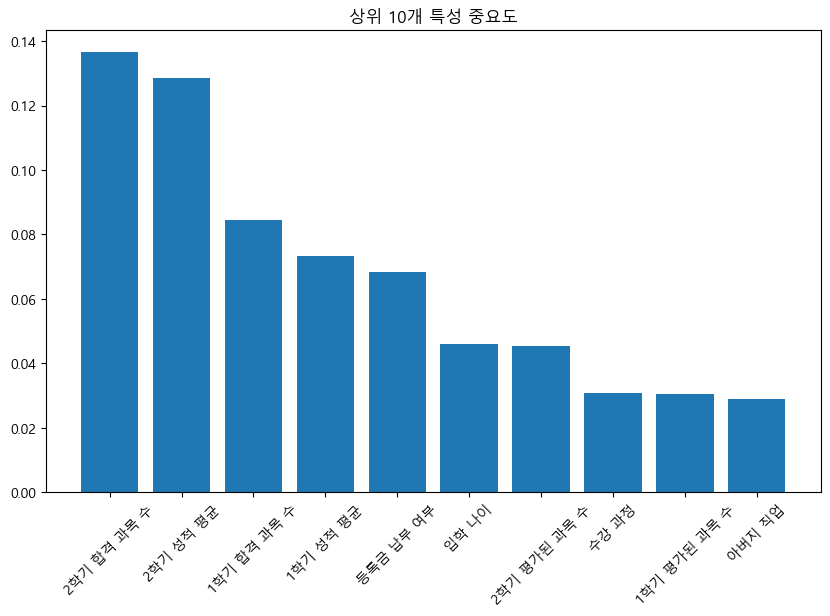

In [50]:
# 특성 중요도
if 'RandomForest' in results:
    rf = RandomForestClassifier().fit(X_train, y_train)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    plt.figure(figsize=(10,6))
    plt.bar(range(10), importances[indices])
    plt.xticks(range(10), X.columns[indices], rotation=45)
    plt.title('상위 10개 특성 중요도')
    plt.show()